In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm, trange

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
with open('hw4_data/nyt_data.txt') as f:
    raw_file = f.readlines()

word_to_id = {}
id_to_word = {}

usa = open('hw4_data/nyt_vocab.dat')
counter = 0
for line in usa:
    word = line.strip()
    word_to_id[word] = counter
    id_to_word[counter] = word
    counter+=1
    
word_list = []
count_list = []

for _,doc in enumerate(raw_file):
    words = doc.strip().split(',')
    w_l = []
    c_l = []
    
    for vocab in words:
        ind, num = vocab.split(':')
        w_l.append(int(ind)-1)
        c_l.append(int(num))
    
    word_list.append(w_l)
    count_list.append(c_l)

In [5]:
padded_words = tf.keras.preprocessing.sequence.pad_sequences(word_list, padding = 'post', value = 0)
padded_counts = tf.keras.preprocessing.sequence.pad_sequences(count_list, padding = 'post', value = 0)

In [6]:
def make_encoder(num_layers, dim, T, V, L, activation = 'relu', residual = False):
    # we build a keras sequential model with prescribed model
    # first embed into the dimensions
    inputs_w = tf.keras.Input(shape = (L, ))
    inputs_c = tf.keras.Input(shape = (L, ))
    embedded = tf.keras.layers.Embedding(V, dim)(inputs_w)
    x = tf.reduce_sum(embedded * tf.expand_dims(inputs_c, axis = -1), axis = 1) # bow
    
    for l in range(num_layers):
        if residual:
            x = tf.keras.layers.Dense(dim, activation=activation)(x) + x
        else:
            x = tf.keras.layers.Dense(dim, activation=activation)(x)
    
    x = tf.keras.layers.Dense(T, activation = None)(x)
    
    encoder = tf.keras.Model(inputs = [inputs_w, inputs_c], outputs=x)
    return encoder

class sampler_indices:

    def __init__(self, N, batch_size):
        self.batch_size = batch_size
        self.i = 0
        self.N = N
        self.ind = tf.range(self.N)
        self.ind = tf.random.shuffle(self.ind)
        
    def take(self, ):
        i0 = self.i%self.N
        i1 = (self.i + self.batch_size)%self.N
        
        if i0 < i1:

            self.i = i1
            return self.ind[i0:i1]
        
        else:
            x0 = self.ind[i0:]
            x1 = self.ind[:i1]
                
            self.i = i1
            self.ind = tf.random.shuffle(self.ind)
            return np.concatenate((x0, x1), axis = 0)
        
@tf.custom_gradient
def naive_natural_gradient_on_backprop(a, ):
    def grad(da):
        Ia = dirichlet_fisher_inv(a)
        da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        return da_tilde
    return tf.identity(a), grad

@tf.custom_gradient
def natural_gradient_on_backprop(a, ):
    def grad(da):
#         Ia = dirichlet_fisher_inv(a)
#         da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        da_tilde = multiply_by_fisher_inv(a, da)
        return da_tilde
    return tf.identity(a), grad

def _calculate_rankone(alphas):
    alpha0 = tf.reduce_sum(alphas, axis = -1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    res = tf.transpose(dg_a0 * tf.ones((alphas.shape[1], alphas.shape[1], alphas.shape[0], )), (2, 0, 1)) # a more readable way of writing this is probably einsum
    return res

def dirichlet_fisher(alphas):
    dg_a = tf.math.polygamma(1., alphas)
    D = tf.linalg.diag(dg_a)
    R1 = _calculate_rankone(alphas)
    
    return D-R1

@tf.function
def dirichlet_fisher_inv(alphas):
    alpha0 = tf.reduce_sum(alphas, axis=-1)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    A_inv = tf.linalg.diag(inv_dg_a) # part 1
    
    A_inv_mul_one = inv_dg_a # part 2
    corr_top = tf.einsum('ki,kj->kij', A_inv_mul_one, A_inv_mul_one)
    corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1)

    return (A_inv - corr_top/tf.reshape(corr_bot, (-1, 1, 1)))

@tf.function
def multiply_by_fisher_inv(alphas, x):
    # alphas is of shape (N, D)
    # x of shape (N, D)
    alpha0 = tf.reduce_sum(alphas, axis=-1, keepdims = True)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    # first get the multiply by inv diag matrix
    A_inv_mul_x = inv_dg_a * x
    Corr_top_mul_x = inv_dg_a * tf.reduce_sum(A_inv_mul_x, axis=-1, keepdims=True) # (N, D) * (N, 1)
    Corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1, keepdims = True)
    Corr_mul_x = Corr_top_mul_x/Corr_bot
    
    return A_inv_mul_x - Corr_mul_x

def calculate_doc_probs3(d_probs, t_probs):
    res = d_probs@t_probs
    return res

### Smoothed LDA No Amortized Inference, Adam 

In [9]:
# build a sampler for document indices
batch_size = 1024
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

T = 30
D = len(word_list)
V = len(word_to_id)
d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
opt = tf.optimizers.Adam(1e-3)
theta_prior = 1.0
beta_prior = 1.0
d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)
t_prior = tfd.Dirichlet(tf.ones((V, )) * beta_prior)
# d_encoder = make_encoder(3, 16, 30, len(word_to_id), padded_words.shape[1], )
# d_encoder.summary()

In [10]:
epochs = 100*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []
topic_records = []
append_every = 50

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = tf.gather(d_logits, i, axis=0)
        d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
        d_sample = d_post.sample()
        
        t_post = tfd.Dirichlet(tf.math.softplus(t_logits))
        t_sample = t_post.sample()
        
        prob_mat = calculate_doc_probs3(d_sample, t_sample)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = tf.reduce_sum(c * lp, axis = 1)
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # (batch_size, )
        loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) # 
    
    grads = tape.gradient(loss, [t_logits, d_logits] )
    opt.apply_gradients(zip(grads, [t_logits, d_logits]))
    loss_records.append(loss)
    tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    if (e+1)%append_every == 0:
        topic_records.append(t_logits.numpy())

-ELBo: 9725285.00: 100%|████████████████████████| 800/800 [00:57<00:00, 13.99it/s]


In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

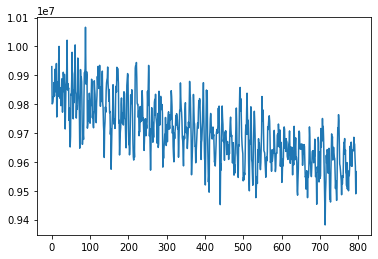

NameError: name 'get_top_words_per_topic' is not defined

In [13]:
plt.plot(moving_average(loss_records, 5))
plt.show()
get_top_words_per_topic(t_logits, top_k=10)

### Smoothed LDA No Amortized Inference, Natural Gradient

In [84]:
# build a sampler for document indices
batch_size = 128
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

T = 30
D = len(word_list)
V = len(word_to_id)
d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
opt = tf.optimizers.SGD(1e-3)
theta_prior = 1.0
beta_prior = 1.0
d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)
t_prior = tfd.Dirichlet(tf.ones((V, )) * beta_prior)
# d_encoder = make_encoder(3, 16, 30, len(word_to_id), padded_words.shape[1], )
# d_encoder.summary()

In [85]:
epochs = 100*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []
topic_records = []
append_every = 50

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = tf.gather(d_logits, i, axis=0)
        d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
        d_sample = d_post.sample()
        
        t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_logits)))
        t_sample = t_post.sample()
        
        prob_mat = calculate_doc_probs3(d_sample, t_sample)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = tf.reduce_sum(c * lp, axis = 1)
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # (batch_size, )
        loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) # 
    
    grads = tape.gradient(loss, [t_logits, d_logits] )
    opt.apply_gradients(zip(grads, [t_logits, d_logits]))
    loss_records.append(loss)
    tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    if (e+1)%append_every == 0:
        topic_records.append(t_logits.numpy())

-ELBo: 9633649.00: 100%|██████████████████████| 6500/6500 [06:59<00:00, 15.48it/s]


In [86]:
def calculate_unique_words(list_of_list):
    res_set = set({})
    for l in list_of_list:
        res_set = res_set.union(set(l))

    return res_set

def get_top_words_per_topic(topics, top_k = 20):
    # doesn't matter they are logits or not.. exp is a monotonic function
    top_words = np.argsort(-topics.numpy(), axis = -1)[:, :top_k]
    res = []
    for t in range(topics.shape[0]):
        res.append([id_to_word[i] for i in top_words[t, :]])
    
    return res

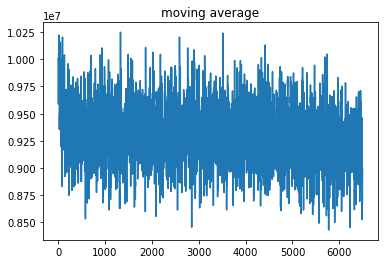

In [87]:
plt.plot(moving_average(loss_records, 5))
plt.title('moving average')
plt.show()
top_words = get_top_words_per_topic(t_logits, top_k=20)
unique_words = calculate_unique_words(top_words)

In [89]:
len(unique_words)

210

Put all the function and training together so that we can run experiment at scale

In [251]:
def train_lda(t_params, 
              d_params, 
              optimizer, 
              theta_prior = 1.,
              beta_prior = 1.,
              ind_sampler = None,
              D = padded_words.shape[0],
              epochs = 100, 
              natural = False, 
              batch_size = 64, 
              verbose = False):
    d_prior = tfd.Dirichlet(tf.ones((t_params.shape[0], )) * theta_prior)
    t_prior = tfd.Dirichlet(tf.ones((t_params.shape[1], )) * beta_prior)
    
    epochs = epochs*(D//batch_size)
    if verbose:
        tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
    else:
        tqdm_range = range(epochs)
    loss_records = []

    for e in tqdm_range:
        i = ind_sampler.take()
        with tf.GradientTape() as tape:
            w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
            d_logits_i = tf.gather(d_params, i, axis=0)
            if natural:
                d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
            else:
                d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
            d_sample = d_post.sample()
            
            if natural:
                t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_params)))
            else:
                t_post = tfd.Dirichlet(tf.math.softplus(t_params))
            t_sample = t_post.sample()

            prob_mat = calculate_doc_probs3(d_sample, t_sample)
            lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
            sum_lp = tf.reduce_sum(c * lp, axis = 1)
            kl = tfd.kl_divergence(d_post, d_prior)

            loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # first take mean, then replicate it D times
            loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) 

        grads = tape.gradient(loss, [t_params, d_params, ] )
        opt.apply_gradients(zip(grads, [t_params, d_params]))
        loss_records.append(loss.numpy())
        if verbose:
            tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    
    return loss_records

In [ ]:
def train_lda2(t_params, 
              d_params, 
              optimizer, 
              theta_prior = 1.,
              beta_prior = 1.,
              ind_sampler = None,
              D = padded_words.shape[0],
              epochs = 100, 
              natural = False, 
              batch_size = 64, 
              verbose = False):
    d_prior = tfd.Dirichlet(tf.ones((t_params.shape[0], )) * theta_prior)
    t_prior = tfd.Dirichlet(tf.ones((t_params.shape[1], )) * beta_prior)
    
    epochs = epochs*(D//batch_size)
    if verbose:
        tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
    else:
        tqdm_range = range(epochs)
    loss_records = []

    for e in tqdm_range:
        i = ind_sampler.take()
        with tf.GradientTape() as tape:
            w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
            d_logits_i = tf.gather(d_params, i, axis=0)
            if natural:
                d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
            else:
                d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
            d_sample = d_post.sample()
            
            if natural:
                t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_params)))
            else:
                t_post = tfd.Dirichlet(tf.math.softplus(t_params))
            t_sample = t_post.sample()

            prob_mat = calculate_doc_probs3(d_sample, t_sample)
            lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
            sum_lp = tf.reduce_sum(c * lp, axis = 1)
            kl = tfd.kl_divergence(d_post, d_prior)

            loss = tf.reduce_mean(-sum_lp + kl) * padded_words.shape[0] # first take mean, then replicate it D times
            loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior)) 

        grads = tape.gradient(loss, [t_params, d_params, ] )
        opt.apply_gradients(zip(grads, [t_params, d_params]))
        loss_records.append(loss.numpy())
        if verbose:
            tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    
    return loss_records

In [253]:
num_runs = 5
batch_sizes = [512, 1024]
optimization_methods = ['ngd', 'adam', 'sgd', 'rms_prop']
epochs = [100,]
counter = 0
max_counter = len(batch_sizes) * len(optimization_methods) * len(epochs)

res = {}

for bs in batch_sizes:
    for om in optimization_methods:
        for e in epochs:
            
            key = "{}/batch_{}epochs_{}".format(bs, e, om)
            res[key] = []
            for _ in tqdm(range(num_runs)):
                i_sampler = sampler_indices(padded_words.shape[0], batch_size)
                d_p = tf.Variable(tf.initializers.GlorotNormal()((D, T)))
                t_p = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
                if om == 'ngd':
                    opt = tf.optimizers.SGD(1e-3)
                    loss_rec = train_lda(t_p, d_p, opt, epochs = e, ind_sampler = i_sampler, natural = True, batch_size = bs)
                elif om == 'adam':
                    opt = tf.optimizers.Adam(1e-3)
                    loss_rec = train_lda(t_p, d_p, opt, epochs = e, ind_sampler = i_sampler, natural = False, batch_size = bs)
                elif om == 'sgd':
                    opt = tf.optimizers.SGD(1e-3)
                    loss_rec = train_lda(t_p, d_p, opt, epochs = e, ind_sampler = i_sampler, natural = False, batch_size = bs)
                elif om == 'rms_prop':
                    opt = tf.optimizers.RMSprop(1e-3)
                    loss_rec = train_lda(t_p, d_p, opt, epochs = e, ind_sampler = i_sampler, natural = False, batch_size = bs)
                
                top_word_rec = get_top_words_per_topic2(t_p.numpy(), top_k=10)
                kl_div_res = tfd.kl_divergence(tfd.Dirichlet(tf.math.softplus(t_p)), tfd.Dirichlet(tf.ones((t_p.shape[1], )) * 1.)) 
                res[key].append({'loss': loss_rec,
                                 'top_words': top_word_rec,
                                 'kl_divs': kl_div_res.numpy()})       
            counter += 1
            print("{} out of {} done".format(counter, max_counter))

1 out of 8 done
2 out of 8 done
3 out of 8 done
4 out of 8 done
5 out of 8 done
6 out of 8 done
7 out of 8 done
8 out of 8 done


In [255]:
def calculate_per_epoch_loss(loss_list, num_per_epoch):
    return np.add.reduceat(loss_list, np.arange(0, len(loss_list), num_per_epoch))/num_per_epoch

def plot_results(results):
    plt.figure(figsize=(12, 10))
    for key in results:
        print("================= {} =================".format(key))
        if key[:2] == '64':
            num_per_epoch = padded_words.shape[0]//64
        elif key[:3] == '128':
            num_per_epoch = padded_words.shape[0]//128
        elif key[:3] == '512':
            num_per_epoch = padded_words.shape[0]//512
        elif key[:4] == '1024':
            num_per_epoch = padded_words.shape[0]//1024
        
        res_key = results[key]
        
        kl_divs_key = [_r['kl_divs'] for _r in res_key]
        uniq_key = [calculate_unique_words(_r['top_words']) for _r in res_key]
        loss_key = [_r['loss'] for _r in res_key]
        
        kl_mean = [np.mean(kl) for kl in kl_divs_key]
        kl_std = [np.std(kl) for kl in kl_divs_key]
        u_mean = np.mean([len(u) for u in uniq_key])
        u_std = np.std([len(u) for u in uniq_key])
        epoch_loss_key = [calculate_per_epoch_loss(l, num_per_epoch) for l in loss_key]
        l_mean = np.array(epoch_loss_key).mean(axis = 0)
        l_std = np.array(epoch_loss_key).std(axis = 0)
        last_epoch_loss_key = [l[-1] for l in epoch_loss_key]
        
        print("kl means: {}, \n kl stdevs: {}".format(kl_mean, kl_std))
        print("mean kl means: {:.2f} +/- {:.2f}".format(np.mean(kl_mean), np.std(kl_mean)))
        print("number of unique words {:.2f} +/- {:.2f}".format(u_mean, u_std))
        print("last epoch loss (by 1000000): {:.2f} +/- {:.2f}".format(np.mean(last_epoch_loss_key)/1000000, np.std(last_epoch_loss_key)/1000000))
        l_s = key.split('_')
        label = ', '.join([l_s[0], l_s[2]]) if len(l_s) == 3 else ', '.join([l_s[0], '_'.join([l_s[2], l_s[3]])])
        plt.errorbar(np.arange(100), l_mean, yerr=l_std, label = label)
    
    plt.legend()
    plt.title("losses for different optimization methods, $\pm 1$ standard error error bar")
    plt.grid()
    plt.show()

In [264]:
examine = res['512/batch_100epochs_ngd']
[examine[i]['top_words'] for i in range(len(examine))][2]

[['home',
  'put',
  'case',
  'thing',
  'life',
  'state',
  'public',
  'man',
  'plan',
  'little'],
 ['percent',
  'company',
  'play',
  'place',
  'home',
  'tell',
  'public',
  'ago',
  'life',
  'group'],
 ['company',
  'percent',
  'state',
  'change',
  'official',
  'member',
  'place',
  'government',
  'yesterday',
  'large'],
 ['official',
  'company',
  'tell',
  'case',
  'plan',
  'man',
  'live',
  'turn',
  'pay',
  'state'],
 ['play',
  'change',
  'man',
  'move',
  'live',
  'official',
  'percent',
  'case',
  'thing',
  'state'],
 ['company',
  'percent',
  'president',
  'states',
  'official',
  'tell',
  'state',
  'group',
  'plan',
  'start'],
 ['percent',
  'company',
  'official',
  'group',
  'report',
  'president',
  'state',
  'market',
  'states',
  'point'],
 ['play',
  'company',
  'state',
  'point',
  'keep',
  'man',
  'states',
  'life',
  'issue',
  'member'],
 ['play',
  'company',
  'move',
  'official',
  'point',
  'put',
  'place',
  't

================= 512/batch_100epochs_rms_prop =================
kl means: [972.1363, 971.9517, 971.7376, 971.78485, 971.842], 
 kl stdevs: [2.4129565, 2.447596, 2.5485106, 2.9386888, 2.6313922]
mean kl means: 971.89 +/- 0.14
number of unique words 36.00 +/- 0.89
last epoch loss (by 1000000): 9.46 +/- 0.15
================= 1024/batch_100epochs_ngd =================
kl means: [1342.7616, 1343.7985, 1341.3348, 1341.1466, 1342.8192], 
 kl stdevs: [23.847193, 17.103218, 18.911774, 22.536903, 17.103207]
mean kl means: 1342.37 +/- 1.00
number of unique words 61.60 +/- 2.06
last epoch loss (by 1000000): 9.37 +/- 0.18
================= 512/batch_100epochs_adam =================
kl means: [874.9173, 875.8367, 874.56476, 875.3756, 875.5457], 
 kl stdevs: [5.297566, 5.46338, 5.159797, 6.52528, 5.80373]
mean kl means: 875.25 +/- 0.45
number of unique words 46.20 +/- 1.33
last epoch loss (by 1000000): 9.58 +/- 0.18
================= 1024/batch_100epochs_rms_prop =================
kl means: [468.41

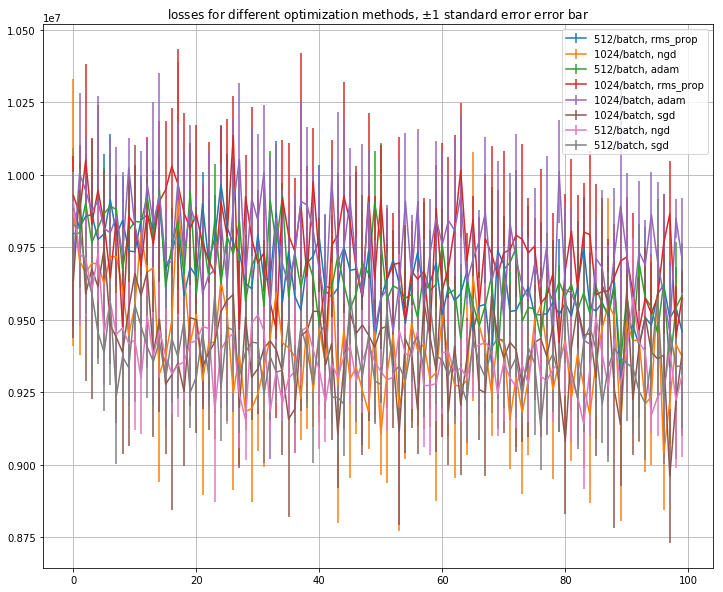

In [256]:
plot_results(res)

### Smoothed LDA with Amortized Inference

In [282]:
# build a sampler for document indices
batch_size = 2048
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

T = 30
D = len(word_list)
V = len(word_to_id)
# d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotNormal()((T, V)))
opt = tf.optimizers.SGD(1e-3)
theta_prior = 1.0
beta_prior = 1.0
d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)
t_prior = tfd.Dirichlet(tf.ones((V, )) * beta_prior)
d_encoder = make_encoder(3, 16, 30, len(word_to_id), padded_words.shape[1], )
d_encoder.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 883)]        0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 883)]        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 883, 16)      48192       input_31[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_15 (Tens [(None, 883, 1)]     0           input_32[0][0]                   
______________________________________________________________________________________

In [283]:
epochs = 1000*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []
topic_records = []
append_every = 50

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = d_encoder([w, c])
        d_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(d_logits_i)))
        d_sample = d_post.sample()
        
        t_post = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(t_logits)))
        t_sample = t_post.sample()
        
        prob_mat = calculate_doc_probs3(d_sample, t_sample)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = c * lp
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = -tf.reduce_sum(tf.reduce_mean(sum_lp, axis = 0)) + tf.reduce_mean(kl)
        loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior))/batch_size
    
    grads = tape.gradient(loss, [t_logits, ] + d_encoder.trainable_variables)
    opt.apply_gradients(zip(grads, [t_logits, ] + d_encoder.trainable_variables))
    loss_records.append(loss)
    tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)
    if (e+1)%append_every == 0:
        topic_records.append(t_logits.numpy())

-ELBo: 1166.47: 100%|██████████| 4000/4000 [36:32<00:00,  2.05it/s]


In [284]:
def get_top_words_per_topic(topics, top_k = 20):
    # doesn't matter they are logits or not.. exp is a monotonic function
    top_words = tf.argsort(-topics, axis = -1)[:, :top_k]
    res = []
    for t in range(topics.shape[0]):
        print('* topic {} *'.format(t))
        print([id_to_word[i.numpy()] for i in top_words[t, :]])
        res.append([id_to_word[i.numpy()] for i in top_words[t, :]])
    
    return res

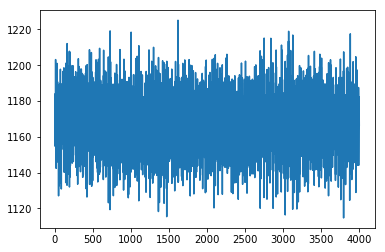

In [285]:
plt.plot(loss_records)
plt.show()

In [286]:
_ = get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['add', 'consider', 'person', 'woman', 'emerge', 'teach', 'machine', 'violate', 'lawmaker', 'cool']
* topic 1 *
['head', 'style', 'term', 'stand', 'really', 'government', 'extend', 'starter', 'brothers', 'phenomenon']
* topic 2 *
['period', 'attention', 'brief', 'board', 'content', 'overnight', 'mortgage', 'equally', 'double', 'deliver']
* topic 3 *
['man', 'rule', 'big', 'accord', 'office', 'study', 'draw', 'technology', 'series', 'natural']
* topic 4 *
['information', 'arrive', 'food', 'guy', 'target', 'fine', 'cultural', 'due', 'replacement', 'critic']
* topic 5 *
['public', 'house', 'problem', 'cause', 'speak', 'mile', 'society', 'return', 'energy', 'demonstrate']
* topic 6 *
['add', 'force', 'state', 'reach', 'states', 'rate', 'parent', 'foreign', 'cold', 'room']
* topic 7 *
['state', 'chance', 'compare', 'statement', 'collection', 'national', 'understand', 'labor', 'rumor', 'ordinary']
* topic 8 *
['produce', 'hundred', 'supporter', 'killing', 'conference', 'dispute',

In [287]:
for i, tl in enumerate(topic_records):
    print("=========================== iteration {} ===========================".format((i+1)*append_every))
    get_top_words_per_topic(tl, top_k=10)

=========================== iteration 50 ===========================
* topic 0 *
['emerge', 'dedicate', 'person', 'machine', 'lawmaker', 'teach', 'violate', 'cool', 'proceed', 'consider']
* topic 1 *
['starter', 'phenomenon', 'style', 'brothers', 'bail', 'extend', 'surrender', 'unemployment', 'preside', 'raising']
* topic 2 *
['overnight', 'brief', 'period', 'mortgage', 'equally', 'content', 'badly', 'calm', 'attention', 'array']
* topic 3 *
['cancel', 'rule', 'natural', 'complaint', 'sweeping', 'crush', 'technology', 'ager', 'corruption', 'blend']
* topic 4 *
['information', 'target', 'suspicion', 'replacement', 'arrive', 'cultural', 'due', 'entitle', 'food', 'guy']
* topic 5 *
['public', 'house', 'religion', 'bulk', 'wheel', 'mile', 'cause', 'society', 'demonstrate', 'energy']
* topic 6 *
['palestinian', 'metal', 'reach', 'cold', 'residential', 'force', 'disagreement', 'add', 'advice', 'shock']
* topic 7 *
['compare', 'rumor', 'collection', 'ordinary', 'pursuit', 'labor', 'stable', '